# EmoNet

Built by ***Jialiang Zhao***

Most data is labelled by ***Jiawei Zhang***

Other data contributors: (From EmoWeb)

***Jiawen Wu, Chenyang Ling, Hao Lu, Jialiang Zhao, (don't know your name)***

----------------------

#### Platform: 
Python 3.6, Google Tensorflow 1.1, Numpy, Jupyter

#### Inspired By:

Beijing Institute of Technology, *Pattern Recognition* by ***Prof. Qi Gao***

Stanford, CS231n *Convolutional Neural Networks in Visual Recognition* by ***Prof. Fei Fei Li***

#### Network Structure:

| Layer Name | Input Size | Output Size | Comment|
| ------ | ------ | ------ | ------ |
|**Input**| 144 x 3| - | - |
|**Augmentation (Affine)**| 144 x 3 | 32 x 32 x 3 | vectorized and augmented|
|**ConvLayer32**| 32 x 32 x 3 | 28 x 28 x 32 | Nonlinear Activation: RELU |
|**2x2 Maxpool**| 28 x 28 x 32 | 28 x 28 x 32 | - |
|**ConvLayer64 1**| 28 x 28 x 32 | 24 x 24 x 64 | Nonlinear Activation: RELU |
|**ConvLayer64 2**| 24 x 24 x 64 | 20 x 20 x 64 | Nonlinear Activation: RELU |
|**2x2 Maxpool**| 20 x 20 x 64 | 20 x 20 x 64 | - |
|**ConvLayer128**| 20 x 20 x 64 | 16 x 16 x 128 | Nonlinear Activation: RELU |
|**2x2 Maxpool**| 16 x 16 x 128 | 16 x 16 x 128 | - |
|**ConvLayer256**| 16 x 16 x 128 | 12 x 12 x 256 | Nonlinear Activation: RELU |
|**2x2 Maxpool**| 12 x 12 x 256 | 6 x 6 x 256 | reduced pooling, for efficiency in FCNN |
|**Affine**| 6 x 6 x 256 = 9216 | 1024 | Nonlinear Activation: RELU | 
|**Dropout**| - | - | reduce overfitting | 
|**Affine**| 1024 | 1024 | Nonlinear Activation: RELU | 
|**Dropout**| - | - | reduce overfitting | 
|**Output Affine**| 1024 | 5 | - |

#### Total Trainable Parameters: 
150 MB *(float32)*

#### Training Cost: 
About ***30 hr*** CPU (aborted) and ***4 hr*** GPU

#### Runtime Cost: 
***5.44 ms +- 103 us*** With GPU (NV Quadro M2000M, 4GB)

***20.32 ms +- 96 us*** With CPU (Intel Xeon v5 1505M, 2 of 4 cores used)


## Load Datasets

In [1]:
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

## Run Model

In [2]:
def run_model(session, predict, loss_val, Xd, yd, drop1, drop2,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         keep_prob1: drop1,
                         keep_prob2: drop2,
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct

## EmoNet Model

![image](https://www.52ml.net/wp-content/uploads/2016/08/vgg.png?_=5821591)

In [3]:
def EmoNet(X,y,keep_prob1,keep_prob2,is_training):
    
    # setup variables
    
    with tf.name_scope("InputFlat") as name_scope:
        inflat = tf.reshape(X,[-1,144*3]) # 144*3
    
    with tf.name_scope("Affine-1") as name_scope:
        Wauger1 = tf.get_variable("Wauger1", regularizer=tf.contrib.layers.l2_regularizer(1.0), 
                                  shape=[144*3, 32*32*3])
        bauger1 = tf.get_variable("bauger1", shape=[1024*3])
        auger1 = tf.matmul(inflat,Wauger1) + bauger1
    
    with tf.name_scope("Augment-1") as name_scope:
        # Augment data from 144*3 to 32*32*3
        aug1 = tf.reshape(auger1,[-1,32,32,3])
        
    with tf.name_scope("ConvRELU1") as name_scope:  
        # Conv 32, 5x5 stride 1
        # before: ? x 32 x 32 x 3
        # after: ? x 28 x 28 x 32
        Wconv1_1 = tf.get_variable("Wconv1_1", shape=[5, 5, 3, 32])
        bconv1_1 = tf.get_variable("bconv1_1", shape=[32])
        conv1_1 = tf.nn.conv2d(aug1, Wconv1_1, strides=[1,1,1,1], padding='VALID') + bconv1_1
        # RELU
        relu1_1 = tf.nn.relu(conv1_1)
        
    with tf.name_scope("Maxpool1") as name_scope:  
        # Maxpool 2x2, stride 1
        # before: ? x 28 x 28 x 32
        # after: ? x 28 x 28 x 32
        maxpool1 = tf.nn.max_pool(relu1_1, [1, 2, 2, 1], [1, 1, 1, 1], padding='SAME')
        
    with tf.name_scope("ConvRELU2") as name_scope:  
        # Conv 64, 5x5 stride 1
        # before: ? x 28 x 28 x 32
        # after: ? x 24 x 24 x 64
        Wconv2_1 = tf.get_variable("Wconv2_1", shape=[5, 5, 32, 64])
        bconv2_1 = tf.get_variable("bconv2_1", shape=[64])
        conv2_1 = tf.nn.conv2d(maxpool1, Wconv2_1, strides=[1,1,1,1], padding='VALID') + bconv2_1
        # RELU
        relu2_1 = tf.nn.relu(conv2_1)
        # Conv 64, 5x5 stride 1
        # before: ? x 24 x 24 x 64
        # after: ? x 20 x 20 x 64
        Wconv2_2 = tf.get_variable("Wconv2_2", shape=[5, 5, 64, 64])
        bconv2_2 = tf.get_variable("bconv2_2", shape=[64])
        conv2_2 = tf.nn.conv2d(relu2_1, Wconv2_2, strides=[1,1,1,1], padding='VALID') + bconv2_2
        # RELU
        relu2_2 = tf.nn.relu(conv2_2)
        
    with tf.name_scope("Maxpool2") as name_scope:  
        # Maxpool 2x2, stride 1
        # before: ? x 20 x 20 x 64
        # after: ? x 20 x 20 x 64
        maxpool2 = tf.nn.max_pool(relu2_2, [1, 2, 2, 1], [1, 1, 1, 1], padding='SAME')
        
    with tf.name_scope("ConvRELU3") as name_scope:  
        # Conv 128, 5x5 stride 1
        # before: ? x 20 x 20 x 64
        # after: ? x 16 x 16 x 128
        Wconv3_1 = tf.get_variable("Wconv3_1", shape=[5, 5, 64, 128])
        bconv3_1 = tf.get_variable("bconv3_1", shape=[128])
        conv3_1 = tf.nn.conv2d(maxpool2, Wconv3_1, strides=[1,1,1,1], padding='VALID') + bconv3_1
        # RELU
        relu3_1 = tf.nn.relu(conv3_1)
        
    with tf.name_scope("Maxpool3") as name_scope:  
        # Maxpool 2x2, stride 1
        # before: ? x 16 x 16 x 128
        # after: ? x 16 x 16 x 128
        maxpool3 = tf.nn.max_pool(relu3_1, [1, 2, 2, 1], [1, 1, 1, 1], padding='SAME')
        
    with tf.name_scope("ConvRELU4") as name_scope:  
        # Conv 246, 5x5 stride 1
        # before: ? x 16 x 16 x 128
        # after: ? x 12 x 12 x 256
        Wconv4_1 = tf.get_variable("Wconv4_1", shape=[5, 5, 128, 256])
        bconv4_1 = tf.get_variable("bconv4_1", shape=[256])
        conv4_1 = tf.nn.conv2d(maxpool3, Wconv4_1, strides=[1,1,1,1], padding='VALID') + bconv4_1
        # RELU
        relu4_1 = tf.nn.relu(conv4_1)
        
    with tf.name_scope("Maxpool4") as name_scope:  
        # Maxpool 2x2, stride 2, VALID padding
        # before: ? x 12 x 12 x 256
        # after: ? x 6 x 6 x 256
        maxpool4 = tf.nn.max_pool(relu4_1, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    
    with tf.name_scope("Flat") as name_scope:
        flat = tf.reshape(maxpool4,[-1,9216]) # 6*6*256
        
    with tf.name_scope("AffineRELUDrop1") as name_scope:
        W1 = tf.get_variable("W1", regularizer=tf.contrib.layers.l2_regularizer(1.0), 
                             shape=[9216, 1024])
        b1 = tf.get_variable("b1", shape=[1024])
        affine1 = tf.matmul(flat,W1) + b1
        
        relu1 = tf.nn.relu(affine1)

        drop1 = tf.nn.dropout(relu1, keep_prob1)
        
    with tf.name_scope("AffineRELUDrop2") as name_scope:
        W2 = tf.get_variable("W2", regularizer=tf.contrib.layers.l2_regularizer(1.0), 
                             shape=[1024, 1024])
        b2 = tf.get_variable("b2", shape=[1024])
        affine2 = tf.matmul(drop1,W2) + b2
        
        relu2 = tf.nn.relu(affine2)
        
        drop2 = tf.nn.dropout(relu2, keep_prob2)
    
    with tf.name_scope("Affine3") as name_scope:
        W3 = tf.get_variable("W3", regularizer=tf.contrib.layers.l2_regularizer(1.0), 
                             shape=[1024, 5])
        b3 = tf.get_variable("b3", shape=[5])
        affine3 = tf.matmul(drop2,W3) + b3
    
    y_out = affine3
    
    return y_out

### Test structure

In [4]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 144, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

# For dropout
keep_prob1 = tf.placeholder(tf.float32)
keep_prob2 = tf.placeholder(tf.float32)

x = np.random.randn(64, 144,3)
drop1 = 0.5
drop2 = 0.5

y_out = EmoNet(X,y,keep_prob1,keep_prob2,is_training)

with tf.Session() as sess:
    with tf.device("/gpu:0"): #"/cpu:0" or "/gpu:0"
        tf.global_variables_initializer().run()

        ans = sess.run(y_out,feed_dict={X:x,keep_prob1:drop1,keep_prob2:drop2,is_training:True})
        #%timeit sess.run(y_out,feed_dict={X:x,keep_prob1:drop1,keep_prob2:drop2,is_training:True})
        print(ans.shape)
        print(np.array_equal(ans.shape, np.array([64, 5])))

(64, 5)
True


## Training
### Load Data

In [10]:
from get_EMOWEB_data import get_EMOWEB_data
from get_EMOWEB_data import trans_back
from get_EMOWEB_data import prepocess_data

In [11]:
dictionary = get_EMOWEB_data(num_training=12040, num_validation=120, num_test=1,pure = False)
X_train = dictionary['X_train']
y_train = dictionary['y_train']
X_val = dictionary['X_val']
y_val = dictionary['y_val']
X_test = dictionary['X_test']
y_test = dictionary['y_test'] 

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (12040, 144, 3)
Train labels shape:  (12040,)
Validation data shape:  (120, 144, 3)
Validation labels shape:  (120,)
Test data shape:  (1, 144, 3)
Test labels shape:  (1,)


## Train

In [ ]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 144, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)
# For dropout
keep_prob1 = tf.placeholder(tf.float32)
keep_prob2 = tf.placeholder(tf.float32)

x = np.random.randn(64, 144,3)
drop1 = 0.3
drop2 = 0.3

y_out = EmoNet(X,y,keep_prob1,keep_prob2,is_training)

reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
reg_constant = 20e-4  # Choose an appropriate one.

optimizer = tf.train.AdamOptimizer(4e-7)
mean_loss = tf.losses.softmax_cross_entropy(tf.one_hot(y,5),logits=y_out) + reg_constant * sum(reg_losses)

train_step = optimizer.minimize(mean_loss)

with tf.Session() as sess:
    saver = tf.train.Saver()
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0" 
        sess.run(tf.global_variables_initializer())
        print("Loaded")
        saver.restore(sess, "checkpoints/checkpoint.data")
        print('Training')
        run_model(sess,y_out,mean_loss,X_train,y_train,drop1,drop2,40,32,50,train_step,False)
        
        saver.save(sess, "checkpoints/checkpoint.data")
        print('Saved')
        
        print('Validation')
        run_model(sess,y_out,mean_loss,X_val,y_val,1.0,1.0,1,64)

Loaded
INFO:tensorflow:Restoring parameters from checkpoints/checkpoint.data
Training
Iteration 0: with minibatch training loss = 0.149 and accuracy of 1
Iteration 50: with minibatch training loss = 0.203 and accuracy of 0.97
Iteration 100: with minibatch training loss = 0.141 and accuracy of 1
Iteration 150: with minibatch training loss = 0.309 and accuracy of 0.97
Iteration 200: with minibatch training loss = 0.155 and accuracy of 1
Iteration 250: with minibatch training loss = 0.158 and accuracy of 1
Iteration 300: with minibatch training loss = 0.138 and accuracy of 1
Iteration 350: with minibatch training loss = 0.193 and accuracy of 1
Epoch 1, Overall loss = 0.182 and accuracy of 0.988
Iteration 400: with minibatch training loss = 0.134 and accuracy of 1
Iteration 450: with minibatch training loss = 0.151 and accuracy of 1
Iteration 500: with minibatch training loss = 0.152 and accuracy of 1
Iteration 550: with minibatch training loss = 0.189 and accuracy of 1
Iteration 600: with

Iteration 5200: with minibatch training loss = 0.192 and accuracy of 1
Iteration 5250: with minibatch training loss = 0.144 and accuracy of 1
Epoch 14, Overall loss = 0.173 and accuracy of 0.99
Iteration 5300: with minibatch training loss = 0.152 and accuracy of 1
Iteration 5350: with minibatch training loss = 0.144 and accuracy of 1
Iteration 5400: with minibatch training loss = 0.172 and accuracy of 0.97
Iteration 5450: with minibatch training loss = 0.144 and accuracy of 1
Iteration 5500: with minibatch training loss = 0.155 and accuracy of 1
Iteration 5550: with minibatch training loss = 0.154 and accuracy of 1
Iteration 5600: with minibatch training loss = 0.167 and accuracy of 1
Iteration 5650: with minibatch training loss = 0.174 and accuracy of 1
Epoch 15, Overall loss = 0.173 and accuracy of 0.99
Iteration 5700: with minibatch training loss = 0.164 and accuracy of 1
Iteration 5750: with minibatch training loss = 0.219 and accuracy of 0.97
Iteration 5800: with minibatch trainin

## Test

INFO:tensorflow:Restoring parameters from checkpoints/checkpoint.data


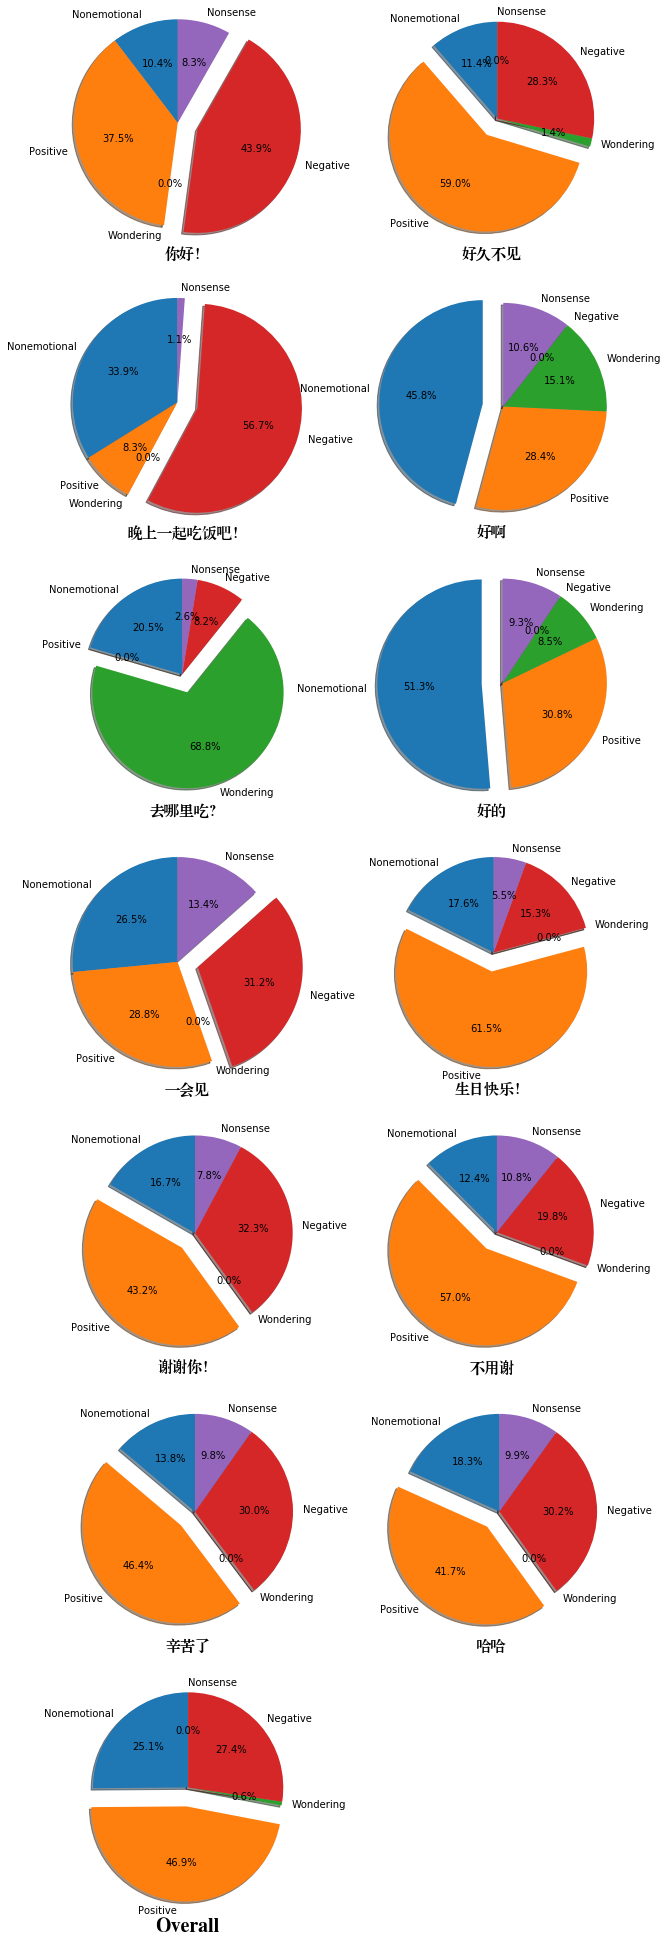

In [9]:
'''
tests = [
    #'干嘛又寄东西来？以后别再寄了。',
    #'为什么啊？',
    #'我说别再寄就别再寄了！你烦不烦啊！',
    #'想着你要过生日了，送你的礼物。',
    #'真是不让人省心！',
    #'哈哈',
    #'你高兴吗？',
    #'我很高兴'
    '你好！',
    '好久不见',
    '晚上一起吃饭吧！',
    '好啊',
    '去哪里吃？',
    '好的',
    '一会见',
    '生日快乐！',
    '谢谢你！',
    '不用谢',
    '辛苦了',
    '哈哈'
]
'''
import re
filename = 'testfile.txt'
testFile = file('filename', 'rb')
reWord = re.compile(u'(?<=\uff1a).+')
lines = testFile.readlines()
tests = []
for line in lines:
    if len(reWord.findall(line.decode('utf8')))>0:
        tests.append(reWord.findall(line.decode('utf8'))[0].encode('utf-8'))

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 144, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

# For dropout
keep_prob1 = tf.placeholder(tf.float32)
keep_prob2 = tf.placeholder(tf.float32)

x_before = []
for test in tests:
    x_line = []
    for c in test.encode('utf-8'):
        x_line.append(int(c))
    x_before.append(x_line)

x = np.zeros([len(x_before), 144, 3], dtype = float)

for cnt in range(len(x_before)):
    data_cur = x_before[cnt]
    xe = np.zeros([3*144], dtype=float)
    tmp = 0
    for i in data_cur:
        xe[tmp] = i
        tmp += 1
        if tmp >= 144*3: break
    xe.reshape((3,144))
    x[cnt] = xe.reshape(144,3).copy()


y_out = EmoNet(X,y,keep_prob1,keep_prob2,is_training)

from matplotlib import font_manager
with tf.Session() as sess:
    saver = tf.train.Saver()
    with tf.device("/gpu:0"): #"/cpu:0" or "/gpu:0"
        tf.global_variables_initializer().run()
        
        #saver.restore(sess, "checkpoints/checkpoint.data")
        saver.restore(sess, "checkpoints/checkpoint.data")
        
        ans = sess.run(y_out,feed_dict={X:x,keep_prob1:1.0,keep_prob2:1.0,is_training:False})
        #timeit sess.run(y_out,feed_dict={X:x,keep_prob1:drop1,keep_prob2:drop2,is_training:True})
        #print(ans)
        datanum = ans.shape[0] + 1 # for overall
        if datanum%2 == 1: datanum += 1
        tmp = 0
        myfont=font_manager.FontProperties(fname='song.ttf')
        fig1, ax1 = plt.subplots(ncols=2,nrows=int(datanum/2), figsize=(2*5, 5*datanum/2))
        for i in ans:
            tmp += 1
            labels = 'Nonemotional', 'Positive', 'Wondering', 'Negative', 'Nonsense'
            i -= np.amin(i)
            i *= 100.0/np.sum(i)
            
            explode = np.array([0,0,0,0,0], dtype=float)
            explode[np.argmax(i)] = 0.2
            sizes = i.tolist()
            plt.subplot(datanum/2, 2, tmp)
            plt.pie(sizes, labels=labels, explode = explode.tolist(), autopct='%1.1f%%', shadow=True, startangle=90)
            plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
            plt.xlabel(tests[tmp-1],fontproperties=myfont,fontsize=15)  
        
        overall = np.mean(ans, axis = 0)
        labels = 'Nonemotional', 'Positive', 'Wondering', 'Negative', 'Nonsense'
        overall -= np.amin(overall)
        overall *= 100.0/np.sum(overall)
        explode = np.array([0,0,0,0,0], dtype=float)
        explode[np.argmax(overall)] = 0.2
        sizes = overall.tolist()
        plt.subplot(datanum/2, 2, tmp+1)
        plt.pie(sizes, labels=labels, explode = explode.tolist(), autopct='%1.1f%%', shadow=True, startangle=90)
        plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
        plt.xlabel('Overall',fontproperties=myfont,fontsize=20)  
        if (ans.shape[0] + 1)%2:
            plt.subplot(datanum/2, 2, tmp+2)
            plt.axis('off')
        plt.show()